#DATAMINING PROJECT
***From Baptiste Danichert & Ahmed Balibala***

**Description:** You have noticed that to improve one’s skills in a new foreign language, it is important to read texts in that language. These texts have to be at the reader’s language level. However, it is difficult to find texts that are close to someone’s knowledge level (A1 to C2). You have decided to build a model for English speakers that predicts the difficulty of a French written text. This can be then used, e.g., in a recommendation system, to recommend texts, e.g, recent news articles that are appropriate for someone’s language level. If someone is at A1 French level, it is inappropriate to present a text at B2 level, as she won’t be able to understand it. Ideally, a text should have many known words and may have a few words that are unknown so that the person can improve.



# 1. Loading the data

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/BapDanSI/DataMiningProject/main/training_data.csv')

# 2. Dataframe analysis


In [ ]:
df.shape

(4800, 3)

-> 4800 rows and 3 columns

In [ ]:
df.isnull().sum()

id            0
sentence      0
difficulty    0
dtype: int64

-> no NAs

In [ ]:
df.duplicated(subset="sentence").value_counts()

False    4800
dtype: int64

-> no duplicate in the data

In [ ]:
display(df.difficulty.value_counts())

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

In [ ]:
def sentence_length(dataframe: pd.DataFrame):
    dataframe["words_no"] = dataframe["sentence"].apply(lambda x: len(x.split()))
    return dataframe

df = sentence_length(df)

We change a little bit the data, because we saw that for instance, our model will predict C2 level if it detect long sentences

# 3. Variable Encoding

* we add a new column called numerical difficulty, **n_diff** 
* Encode Al, A2, B1, B2, C1, C2 into numerical variables like:
    
    * A1 = 1
    * A2 = 2
    * B1 = 3
    * B2 = 4
    * C1 = 5
    * C2 = 6

In [ ]:
df['n_diff'] = df['difficulty'].replace(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [1,2,3,4,5,6])
df.head(5)

,id,sentence,difficulty,words_no,n_diff
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,5
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1
2,2,Le test de niveau en français est sur le site ...,A1,13,1
3,3,Est-ce que ton mari est aussi de Boston?,A1,8,1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,34,3


#4. Feature Extraction
We decided to extract the followinig features: 
<br> The feautures to be extracted from the data includes:
* **char_no:** The number of charater per sentence
* **words_no:** The number of words per sentence
* **avg_wordLength:** Average word length per sentence
* **stopwords_no:** The number of stopwords per sentence
* **words_no_to_stopwords_no_ratio:** The ration of the number of words to number of stopwords per sentence
* **pos:** parts of speech per word
* **word_diff:** Each word difficulty
* **avg_word_diff:** Average word difficulty per sentence
* **word_freq:** Word frequency score 
* **avg_word_freq:** Average word frequency per sentence
* **readability:** The readability score from flesch

In order to process our data, we used Spacy (https://spacy.io/).

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download fr_core_news_sm
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stopwords
from collections import Counter
import string
import nltk
import spacy
nlp = spacy.load("fr_core_news_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-11 12:01:08.934199: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 22.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


###Part of Speech: 
SpaCy can parse and tag a given Doc. This is where the trained pipeline and its statistical models come in, which enable spaCy to make predictions of which tag or label most likely applies in this context.

In [ ]:
def return_POS(sentence):
    doc = nlp(sentence) # Tokenize the sentence
    return [(X, X.pos_) for X in doc]   # Return tag of each token

def POS_counter(sentence: string):
    pos = return_POS(sentence)  # Take a token with its tags and count each elements
    counter = Counter([t[1] for t in pos])
    return counter

###Entity regognition: 
SpaCy can recognize various types of named entities in a document, by asking the model for a prediction

In [ ]:
def return_NER(sentence):
    doc = nlp(sentence) # Tokenize the sentence
    return [(X.text, X.label_) for X in doc.ents] # Return text and label for each sentence

def NER_counter(sentence: string):
    ner = return_NER(sentence) # Take a sentence with its text & label and couint each elements
    counter = Counter([t[1] for t in ner])
    return counter

###Features extraction:
We create a new column by the name **pos** and writing the parts of speech or the type of each word in the corresponding sentence

In [ ]:
def features_extraction(dataframe: pd.DataFrame):
    dataframe["char_no"] = dataframe["sentence"].apply(len)
    dataframe["avg_wordLength"] = dataframe['sentence'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))
    dataframe['stopwords_no'] = dataframe['sentence'].apply(lambda x: np.sum([1 for word in x.split(' ') if word in fr_stopwords]))
    
    for index, row in df.iterrows(): #get specific features from each row
        counter_pos = POS_counter(row['sentence']) # Part-Of-Speech
        for x in counter_pos:
            dataframe.loc[index, x] = counter_pos[x]
        
        counter_ner = NER_counter(row['sentence']) # Entity Recognizer
        for x in counter_ner:
            dataframe.loc[index, x] = counter_ner[x]
        
        current_pos = return_POS(row.sentence) # Number of words before the first verb in each sentence
        iter_current_pos = [str(y) for t in current_pos for y in t]
        if 'VERB' in iter_current_pos:
            dataframe.loc[index, 'num_words_before_first_verb'] = (iter_current_pos.index('VERB') + 1) // 2
        else:
            dataframe.loc[index, 'num_words_before_first_verb'] = 0
    
    return dataframe

df = features_extraction(df)
df.head(2)

,id,sentence,difficulty,words_no,n_diff,char_no,avg_wordLength,stopwords_no,DET,NOUN,...,SCONJ,PROPN,LOC,NUM,PER,X,ORG,SYM,SPACE,INTJ
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,5,255,5.736842,15.0,3.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1,62,4.250000,5.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Word separation from the sentences. 

We use fr_core_news_sm from the SpacY library.
The wordstats library give us statitics about common word use.

In [ ]:
import fr_core_news_sm
!pip install wordstats
from wordstats import Word, common_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We create a new column called **word** and added the tockenized sentence in each of the row.

In [ ]:
df["word"] = ""
sp = fr_core_news_sm.load()
len = df.shape[0]
line = 0

while line<len:
    text = str(df["sentence"].iloc[line])
    theDoc = sp(text)
    token_list = []
    new_List = []
    for w in theDoc:
        token_list.append(w.text)
        if (w.pos_ == "PROPN") or (w.pos_ == "NUM"):
            token_list.remove(w.text)
    df["word"].iloc[line] = token_list
    line += 1

df.head(5)

,id,sentence,difficulty,words_no,n_diff,char_no,avg_wordLength,stopwords_no,DET,NOUN,...,PROPN,LOC,NUM,PER,X,ORG,SYM,SPACE,INTJ,word
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,5,255,5.736842,15.0,3.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Les, coûts, kilométriques, réels, peuvent, di..."
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1,62,4.250000,5.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Le, bleu, ,, c', est, ma, couleur, préférée, ..."
2,2,Le test de niveau en français est sur le site ...,A1,13,1,66,4.153846,6.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Le, test, de, niveau, en, français, est, sur,..."
3,3,Est-ce que ton mari est aussi de Boston?,A1,8,1,40,4.125000,5.0,NaN,2.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Est, -ce, que, ton, mari, est, aussi, de, ?]"
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,34,3,209,5.176471,13.0,4.0,10.0,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Dans, les, écoles, de, commerce, ,, dans, les..."


### Punctuation remove


In [ ]:
#import relevant libraries
punct = string.punctuation

In [ ]:
line = 0 
len = df.shape[0]
while line<len:
    diffic = df.word.iloc[line]
    for i in diffic:
        if (i in punct):
            diffic.remove(i)
    line += 1

#overview of the df
# df.head(5)

### word_diff 

Shows the difficulty score of each word used in each sentence
Here, we use wordstats.

In [ ]:
# Get the word difficulty
df["word_diff"] = ""
line = 0 
len = df.shape[0]
while line<len:
    newList = []
    for w in df.word.iloc[line]:
        newList.append(Word.stats(w, "fr").difficulty)
    df.word_diff.iloc[line] = newList
    line += 1

###avg_word_diff

Gives the average word difficulty per sentence

In [ ]:
# Get the average word difficulty
df["avg_word_diff"] = ""
line = 0 
len = df.shape[0]
while line<len:
    total = 0
    nb = 0
    for i in df.word_diff.iloc[line]:
        total += i
        nb += 1
        df.avg_word_diff.iloc[line] = total/nb 
    line += 1

#overview
df.head(2)

,id,sentence,difficulty,words_no,n_diff,char_no,avg_wordLength,stopwords_no,DET,NOUN,...,NUM,PER,X,ORG,SYM,SPACE,INTJ,word,word_diff,avg_word_diff
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,5,255,5.736842,15.0,3.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Les, coûts, kilométriques, réels, peuvent, di...","[0.0, 1, 1, 0.15, 0.01, 1, 1, 0.0, 0.11, 1, 0....",0.3035
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1,62,4.250000,5.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Le, bleu, c', est, ma, couleur, préférée, mai...","[0.0, 0.03, 1, 0.0, 0.0, 0.02, 0.06, 0.0, 0.0,...",0.152857


### word_freq
Calculated the word frequency score

In [ ]:
df["word_freq"] = ""
line = 0
while line<len:
    new_List = []
    for w in df.word.iloc[line]:
        new_List.append(Word.stats(w, "fr").frequency)
    df.word_freq.iloc[line] = new_List
    line += 1
    
#overview of the df
# df.head(5)    

###avg_word_freq
Calculate the average word frequency per sentence

In [ ]:
df["avg_word_freq"] = ""
line = 0
while line<len:
    tot = 0
    nb = 0
    for i in df.word_freq.iloc[line]:
        tot += i
        nb += 1
        df.avg_word_freq.iloc[line] = tot/nb
    line += 1
    
#overview of the df
df.head(2)  

,id,sentence,difficulty,words_no,n_diff,char_no,avg_wordLength,stopwords_no,DET,NOUN,...,X,ORG,SYM,SPACE,INTJ,word,word_diff,avg_word_diff,word_freq,avg_word_freq
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,5,255,5.736842,15.0,3.0,14.0,...,NaN,NaN,NaN,NaN,NaN,"[Les, coûts, kilométriques, réels, peuvent, di...","[0.0, 1, 1, 0.15, 0.01, 1, 1, 0.0, 0.11, 1, 0....",0.3035,"[14.77, 0, 0, 7.38, 10.58, 0, 0, 14.3, 7.81, 0...",8.4945
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1,62,4.250000,5.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,"[Le, bleu, c', est, ma, couleur, préférée, mai...","[0.0, 0.03, 1, 0.0, 0.0, 0.02, 0.06, 0.0, 0.0,...",0.152857,"[15.33, 9.42, 0, 15.6, 13.33, 9.46, 8.53, 14.1...",10.977857


###readability
Calculated the readability score feature using the flesch

In [ ]:
#import relevent libraries
!pip install textstat
import textstat
textstat.set_lang(lang="fr")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df["readability"] = ""
df["readability"] = df.sentence.apply(textstat.flesch_reading_ease)

In [ ]:
df.dtypes

id                               int64
sentence                        object
difficulty                      object
words_no                         int64
n_diff                           int64
char_no                          int64
avg_wordLength                 float64
stopwords_no                   float64
DET                            float64
NOUN                           float64
ADJ                            float64
VERB                           float64
ADP                            float64
PUNCT                          float64
CCONJ                          float64
ADV                            float64
num_words_before_first_verb    float64
PRON                           float64
AUX                            float64
MISC                           float64
SCONJ                          float64
PROPN                          float64
LOC                            float64
NUM                            float64
PER                            float64
X                        

###Data conversion
1. objects -> numeric
2. NaN (mean and 0)

In [ ]:
#covert them to numeric
df.avg_word_diff = pd.to_numeric(df.avg_word_diff)
df.avg_word_freq = pd.to_numeric(df.avg_word_freq)

In [ ]:
df.isnull().sum()

id                                0
sentence                          0
difficulty                        0
words_no                          0
n_diff                            0
char_no                           0
avg_wordLength                    0
stopwords_no                      0
DET                             578
NOUN                            310
ADJ                            1770
VERB                            593
ADP                             822
PUNCT                           385
CCONJ                          2876
ADV                            2104
num_words_before_first_verb       0
PRON                           1101
AUX                            2441
MISC                           4435
SCONJ                          3636
PROPN                          3411
LOC                            4181
NUM                            4143
PER                            4267
X                              4749
ORG                            4646
SYM                         

In [ ]:
df['avg_word_freq'].fillna(df['avg_word_freq'].mean(), inplace=True)
df = df.fillna(0)

Final Data document that will be used for the next part: 

In [ ]:
df.to_csv('final.csv')
%reset -f

In [ ]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

This part is now loading the final data that includes features

In [ ]:
df1 = pd.read_csv('final.csv', index_col='id')

In [ ]:
df1.head(2)

,Unnamed: 0,sentence,difficulty,words_no,n_diff,char_no,avg_wordLength,stopwords_no,DET,NOUN,...,ORG,SYM,SPACE,INTJ,word,word_diff,avg_word_diff,word_freq,avg_word_freq,readability
id,,,,,,,,,,,,,,,,,,,,,
0,0,Les coûts kilométriques réels peuvent diverger...,C1,38,5,255,5.736842,15.0,3.0,14.0,...,0.0,0.0,0.0,0.0,"['Les', 'coûts', 'kilométriques', 'réels', 'pe...","[0.0, 1, 1, 0.15, 0.01, 1, 1, 0.0, 0.11, 1, 0....",0.303500,"[14.77, 0, 0, 7.38, 10.58, 0, 0, 14.3, 7.81, 0...",8.494500,43.31
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,1,62,4.250000,5.0,3.0,3.0,...,0.0,0.0,0.0,0.0,"['Le', 'bleu', ""c'"", 'est', 'ma', 'couleur', '...","[0.0, 0.03, 1, 0.0, 0.0, 0.02, 0.06, 0.0, 0.0,...",0.152857,"[15.33, 9.42, 0, 15.6, 13.33, 9.46, 8.53, 14.1...",10.977857,99.14


We computed the Base Rate (Default Rate) over the full size of the dataset named data to determine whether the accuracy we found is good or bad. <br>Base Rate = (most frequent class) / (total observations)

In [ ]:
base_rate = max(df1.value_counts('difficulty'))/df1.shape[0]
print('Base rate:', round(base_rate,2))

Base rate: 0.17


# 5. Classification Algorithms

Dependent variable (y) is the column named "difficulty".
<br>We split the data into 80% training and 20% test set.


In [ ]:
#import relevant libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

### Standardization

Standardize numerical features only. They should have a mean of 0 and a standard deviation of 1.

The numerical features are:
*   char_no
*   words_no
*   avg_wordLength
*   stopwords_no
*   avg_word_diff
*   avg_word_freq
*   readability

We Standardized only the numerical features (not the categorical features) to have mean of 0 and standad deviation of 1.

In [ ]:
#standardizing all the numerical variables
normalize_col = ['char_no']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['words_no']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['avg_wordLength']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['stopwords_no']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['avg_word_diff']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['avg_word_freq']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['readability']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['DET']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['NOUN']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['ADJ']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['VERB']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['ADP']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['CCONJ']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['ADV']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['AUX']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

normalize_col = ['PRON']
df1[normalize_col]=(df1[normalize_col]-df1[normalize_col].min()
                   )/(df1[normalize_col].max()-df1[normalize_col].min())

We determined the dependent variable as y and the set of independent variables as X.

In [ ]:
y_class = df1['difficulty']
X_class = df1[['char_no', 'words_no', 'avg_wordLength', 'stopwords_no', 'avg_word_diff', 'avg_word_freq', 'readability',
            'DET', 'NOUN', 'ADJ', 'VERB', 'ADP', 'CCONJ', 'ADV', 'AUX', 'PRON']]

In [ ]:
#A function to evaluate the model properties
def evaluate(true, pred):
    precision = precision_score(true, pred, average='macro')
    recall = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

### i. Logistic Regression.
For this section, train a logistic regression model and use the already standardized difficulty level dataset.

We trained a Logistic Regression model with cross validation on the standardized features. The features came from the dataset named df1 that we created from sentence.

Use the following parameters for the LogisticRegressionCV():

* Set the cross-validation to 5 folds
* Set the maximum interation to 1000
* Set the random state to 50

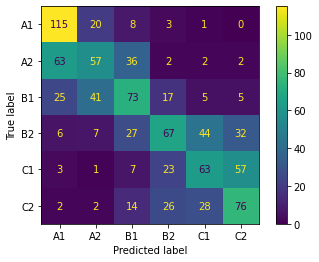

In [ ]:
#import additional libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix

std = StandardScaler()
scaler = StandardScaler()


X_trainLRC, X_testLRC, y_trainLRC, y_testLRC = train_test_split(X_class, y_class, test_size = 0.20, random_state = 50)

logisticRegr = LogisticRegressionCV(solver='lbfgs', cv=5, max_iter=1000)
logisticRegr.fit(X_trainLRC, y_trainLRC)

y_pred_logR=logisticRegr.predict(X_testLRC)
y_pred_train_logR=logisticRegr.predict(X_trainLRC)

disp = plot_confusion_matrix(logisticRegr, X_testLRC, y_testLRC)

In [ ]:
evaluate(y_testLRC, y_pred_logR)

CONFUSION MATRIX:
[[115  20   8   3   1   0]
 [ 63  57  36   2   2   2]
 [ 25  41  73  17   5   5]
 [  6   7  27  67  44  32]
 [  3   1   7  23  63  57]
 [  2   2  14  26  28  76]]
ACCURACY SCORE:
0.4698
CLASSIFICATION REPORT:
	Precision: 0.4655
	Recall: 0.4771
	F1_Score: 0.4647


### ii. kNNeighbours

Use GridSearchCV from sklearn.model_selection to find the best value of k that should be used for the K-Nearest Neighbours (KNN) algorithm.

Use a range value of hyperparmeter k from 1 to 2. This range is a parameter used by the GridSearchCV to define the best value of k.
Set the cross-validation to 5 folds.

{'knn__leaf_size': 50, 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy of word category with KNN is:  0.43
The F1 score for the test is:  0.43


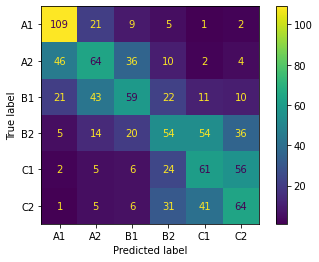

In [ ]:
# Grid Search - hyperparameter tuning
#import additional libraries
from sklearn.neighbors import KNeighborsClassifier

X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X_class, y_class, test_size = 0.20, random_state = 50)

# Define the model
KNN = Pipeline([('knn', KNeighborsClassifier())])

# Define parameters to test
param_knn = {
      'knn__leaf_size': (50, 70, 60,10),
      'knn__p': (1,2),                        # Manhattan/Euclidian distance
      'knn__n_neighbors': (13, 15, 17, 19),   
      'knn__weights': ('uniform', 'distance')
    } 

#fit the model
grid_search_knn = GridSearchCV(KNN, param_knn, cv = 5)
grid_search_knn.fit(X_trainKNN,y_trainKNN)
print(grid_search_knn.best_params_)

Accuracy_basic_knn = grid_search_knn.score(X_testKNN, y_testKNN)
print('Accuracy of word category with KNN is: ', round(Accuracy_basic_knn, 2))

pred_yKNN = grid_search_knn.predict(X_testKNN)
f1_class_KNN = f1_score(y_testKNN, pred_yKNN, average='macro') 

print("The F1 score for the test is: ", round(f1_class_KNN,2))

disp = plot_confusion_matrix(grid_search_knn, X_testKNN, y_testKNN)

In [ ]:
evaluate(y_testKNN, pred_yKNN)

CONFUSION MATRIX:
[[109  21   9   5   1   2]
 [ 46  64  36  10   2   4]
 [ 21  43  59  22  11  10]
 [  5  14  20  54  54  36]
 [  2   5   6  24  61  56]
 [  1   5   6  31  41  64]]
ACCURACY SCORE:
0.4281
CLASSIFICATION REPORT:
	Precision: 0.4247
	Recall: 0.4359
	F1_Score: 0.4270


###  iii. Decision Trees

In [ ]:
#import additional libraries
from sklearn.tree import DecisionTreeClassifier

Accuracy of DT no optimization is:  0.36
{'DT__max_depth': 3, 'DT__min_samples_split': 5}
Accuracy of Decision tree optimized is:  0.38
TheF1 score for the test is:  0.31


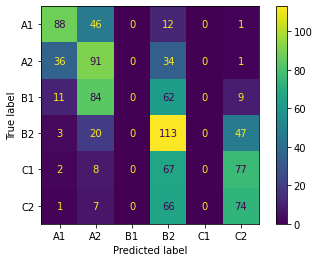

In [ ]:
X_trainDT, X_testDT, y_trainDT, y_testDT = train_test_split(X_class, y_class, test_size = 0.20, random_state = 50)

pipeDT = Pipeline([('DT', DecisionTreeClassifier())])                            

pipeDT.fit(X_trainDT, y_trainDT)
print('Accuracy of DT no optimization is: ', round(pipeDT.score(X_testDT, y_testDT), 2))

### Optimization of hyperparameters
param_DT = {'DT__min_samples_split' : [5],'DT__max_depth': [3]} # Started really large (10, 50, 100, 200) then reduced to get between 70 and 75
grid_search_DT = GridSearchCV(pipeDT, param_DT, cv = 5)
grid_search_DT.fit(X_trainDT, y_trainDT)

print(grid_search_DT.best_params_)
print('Accuracy of Decision tree optimized is: ', round(grid_search_DT.score(X_testDT, y_testDT), 2))


pred_DT = grid_search_DT.predict(X_testDT)
f1_class_DT = f1_score(y_testDT, pred_DT, average='macro') 

print("TheF1 score for the test is: ", round(f1_class_DT,2))

disp = plot_confusion_matrix(grid_search_DT, X_testDT, y_testDT)

In [ ]:
evaluate(y_testDT, pred_DT)

CONFUSION MATRIX:
[[ 88  46   0  12   0   1]
 [ 36  91   0  34   0   1]
 [ 11  84   0  62   0   9]
 [  3  20   0 113   0  47]
 [  2   8   0  67   0  77]
 [  1   7   0  66   0  74]]
ACCURACY SCORE:
0.3812
CLASSIFICATION REPORT:
	Precision: 0.2755
	Recall: 0.3796
	F1_Score: 0.3137


### iv. Random Forest Model

In [ ]:
#import relevant libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

{'RF__bootstrap': True, 'RF__criterion': 'gini', 'RF__n_estimators': 19}
Accuracy of random forest :  0.4
TheF1 score for the test is:  0.4


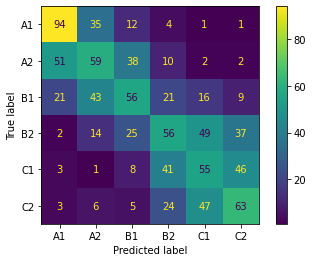

In [ ]:
X_trainRF, X_testRF, y_trainRF, y_testRF= train_test_split(X_class, y_class, test_size = 0.20, random_state = 50)

RF = Pipeline([('RF', RandomForestClassifier())])

param_RF = {
      'RF__bootstrap': [True,False],  
      'RF__n_estimators': [15,16,17,18,19,20],
      'RF__criterion': ["gini", "entropy"], 
}
    
grid_search_RF = GridSearchCV(RF, param_RF, cv = 5)
grid_search_RF.fit(X_trainRF, y_trainRF)

print(grid_search_RF.best_params_)
print('Accuracy of random forest : ', round(grid_search_RF.score(X_testRF, y_testRF), 2))

pred_RF = grid_search_RF.predict(X_testRF)
f1_class_RF = f1_score(y_testRF, pred_RF, average='macro') 

print("TheF1 score for the test is: ", round(f1_class_RF,2))

disp = plot_confusion_matrix(grid_search_RF, X_testRF, y_testRF)

In [ ]:
evaluate(y_testRF, pred_RF)

CONFUSION MATRIX:
[[94 35 12  4  1  1]
 [51 59 38 10  2  2]
 [21 43 56 21 16  9]
 [ 2 14 25 56 49 37]
 [ 3  1  8 41 55 46]
 [ 3  6  5 24 47 63]]
ACCURACY SCORE:
0.3990
CLASSIFICATION REPORT:
	Precision: 0.3973
	Recall: 0.4050
	F1_Score: 0.3996


### Comparing the models

In [ ]:
#create functions to get the models properties
def accuracy(true, pred):
    recall = recall_score(true, pred, average='macro')
    return round(accuracy_score(true, pred), 4)

def precision(true, pred):
    recall = recall_score(true, pred, average='macro')
    precision = precision_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    return round(precision, 4)
    
def recall(true, pred):
    recall = recall_score(true, pred, average='macro')
    precision = precision_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    return round(recall, 4)
    
def f_1(true, pred):
    recall = recall_score(true, pred, average='macro')
    precision = precision_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    return round(f1, 4)

In [ ]:
#create a dataframe to show the different performance by models.
df_comparison = pd.DataFrame(columns=['Score_name', 'Logistic Regression', 'kNNeighbours', 'Decision Trees', 'Random Forest Model', 
                                      ])

df_comparison['Score_name'] = ['Precisions', 'Recall', 'F1-score', 'Accuracy']

#fill the figures
df_comparison['Logistic Regression'] = [precision(y_testLRC, y_pred_logR), 
                                        recall(y_testLRC, y_pred_logR), 
                                        f_1(y_testLRC, y_pred_logR), 
                                        accuracy(y_testLRC, y_pred_logR)]

df_comparison['kNNeighbours'] = [precision(y_testKNN, pred_yKNN), 
                                 recall(y_testKNN, pred_yKNN), 
                                 f_1(y_testKNN, pred_yKNN), 
                                 accuracy(y_testKNN, pred_yKNN)]

df_comparison['Decision Trees'] = [precision(y_testDT, pred_DT), 
                                   recall(y_testDT, pred_DT), 
                                   f_1(y_testDT, pred_DT), 
                                   accuracy(y_testDT, pred_DT)]

df_comparison['Random Forest Model'] = [precision(y_testRF, pred_RF), 
                                        recall(y_testRF, pred_RF), 
                                        f_1(y_testRF, pred_RF), 
                                        accuracy(y_testRF, pred_RF)]

df_comparison

,Score_name,Logistic Regression,kNNeighbours,Decision Trees,Random Forest Model
0,Precisions,0.4655,0.4247,0.2755,0.3973
1,Recall,0.4771,0.4359,0.3796,0.4050
2,F1-score,0.4647,0.4270,0.3137,0.3996
3,Accuracy,0.4698,0.4281,0.3812,0.3990


**Best model: Logistic Regression**

# 6. Getting the csv. for submission (unlabelled data)
This code is exactly a copy paste of the one above

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stopwords
from collections import Counter
import string
import nltk
import spacy
nlp = spacy.load("fr_core_news_sm")
import fr_core_news_sm
from wordstats import Word, common_words
import textstat
textstat.set_lang(lang="fr")

In [112]:
df3 = pd.read_csv('https://raw.githubusercontent.com/BapDanSI/DataMiningProject/main/unlabelled_test_data.csv', index_col='id')

In [113]:
def clean_data(df3):
    df3.sentence = df3.sentence.astype('str')
    def sentence_lengths(dataframe: pd.DataFrame):
        dataframe["words_no"] = dataframe["sentence"].apply(lambda wrd: len(wrd.split()))
        return dataframe
    df3 = sentence_lengths(df3)

    def return_POS(sentence):
        doc = nlp(sentence) # Tokenize the sentence
        return [(X, X.pos_) for X in doc]   # Return tag of each token

    def POS_counter(sentence: string):
        pos = return_POS(sentence)  # Take a token with its tags and count each elements
        counter = Counter([t[1] for t in pos])
        return counter

    def return_NER(sentence):
        doc = nlp(sentence) # Tokenize the sentence
        return [(X.text, X.label_) for X in doc.ents] # Return text and label for each sentence

    def NER_counter(sentence: string):
        ner = return_NER(sentence) # Take a sentence with its text & label and couint each elements
        counter = Counter([t[1] for t in ner])
        return counter

    def features_extraction(dataframe):
        dataframe["char_no"] = dataframe["sentence"].apply(len)
        dataframe["avg_wordLength"] = dataframe['sentence'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))
        dataframe['stopwords_no'] = dataframe['sentence'].apply(lambda x: np.sum([1 for word in x.split(' ') if word in fr_stopwords]))

        for index, row in df3.iterrows(): #get specific features from each row
            counter_pos = POS_counter(row['sentence']) # Part-Of-Speech
            for x in counter_pos:
                dataframe.loc[index, x] = counter_pos[x]

            counter_ner = NER_counter(row['sentence']) # Entity Recognizer
            for x in counter_ner:
                dataframe.loc[index, x] = counter_ner[x]

            current_pos = return_POS(row.sentence) # Number of words before the first verb in each sentence
            iter_current_pos = [str(y) for t in current_pos for y in t]
            if 'VERB' in iter_current_pos:
                dataframe.loc[index, 'num_words_before_first_verb'] = (iter_current_pos.index('VERB') + 1) // 2
            else:
                dataframe.loc[index, 'num_words_before_first_verb'] = 0

        return dataframe

    df3 = features_extraction(df3)
    df3["word"] = ""
    sp = fr_core_news_sm.load()
    len2 = df3.shape[0]
    line = 0

    while line< len2:
        text = str(df3["sentence"].iloc[line])
        theDoc = sp(text)
        token_list = []
        new_List = []
        for w in theDoc:
            token_list.append(w.text)
            if (w.pos_ == "PROPN") or (w.pos_ == "NUM"):
                token_list.remove(w.text)
        df3["word"].iloc[line] = token_list
        line += 1

    df3["word_diff"] = ""
    line = 0 
    len2 = df3.shape[0]
    while line<len2:
        newList = []
        for w in df3.word.iloc[line]:
            newList.append(Word.stats(w, "fr").difficulty)
        df3.word_diff.iloc[line] = newList
        line += 1
        
    # Get the average word difficulty
    df3["avg_word_diff"] = ""
    line = 0 
    len2 = df3.shape[0]
    while line<len2:
        total = 0
        nb = 0
        for i in df3.word_diff.iloc[line]:
            total += i
            nb += 1
            df3.avg_word_diff.iloc[line] = total/nb 
        line += 1

    #import relevant libraries
    punct = string.punctuation
    line = 0 
    len2 = df3.shape[0]
    while line<len2:
        diffic = df3.word.iloc[line]
        for i in diffic:
            if (i in punct):
                diffic.remove(i)
        line += 1
        
    df3["word_freq"] = ""
    line = 0
    while line<len2:
        new_List = []
        for w in df3.word.iloc[line]:
            new_List.append(Word.stats(w, "fr").frequency)
        df3.word_freq.iloc[line] = new_List
        line += 1

    df3["avg_word_freq"] = ""
    line = 0
    while line<len2:
        tot = 0
        nb = 0
        for i in df3.word_freq.iloc[line]:
            tot += i
            nb += 1
            df3.avg_word_freq.iloc[line] = tot/nb
        line += 1

    df3["readability"] = ""
    df3["readability"] = df3.sentence.apply(textstat.flesch_reading_ease)
    #covert them to numeric
    df3.avg_word_diff = pd.to_numeric(df3.avg_word_diff)
    df3.avg_word_freq = pd.to_numeric(df3.avg_word_freq)
    df3['avg_word_freq'].fillna(df3['avg_word_freq'].mean(), inplace=True)
    df3 = df3.fillna(0)
    
    df3.drop(['word', 'word_diff', 'word_freq'], axis=1,inplace=True)
    
    #standardizing all the numerical variables
    normalize_col = ['char_no']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['words_no']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['avg_wordLength']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['stopwords_no']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['avg_word_diff']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['avg_word_freq']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['readability']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['DET']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['NOUN']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['ADJ']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['VERB']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['ADP']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['CCONJ']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['ADV']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['AUX']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())

    normalize_col = ['PRON']
    df3[normalize_col]=(df3[normalize_col]-df3[normalize_col].min()
                       )/(df3[normalize_col].max()-df3[normalize_col].min())
    
    return df3

In [114]:
testdf= clean_data(df3)
testdf.fillna(0)

,sentence,words_no,char_no,avg_wordLength,stopwords_no,PRON,VERB,DET,NOUN,AUX,...,PER,MISC,NUM,LOC,SPACE,ORG,X,avg_word_diff,avg_word_freq,readability
id,,,,,,,,,,,,,,,,,,,,,
0,Nous dûmes nous excuser des propos que nous eû...,0.051282,0.057359,0.413793,0.051948,0.173913,0.136364,0.029412,0.029412,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339750,0.578120,0.742127
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,0.076923,0.079004,0.374384,0.077922,0.130435,0.136364,0.058824,0.029412,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143438,0.830207,0.760651
2,"Et, paradoxalement, boire froid n'est pas la b...",0.044872,0.056277,0.490421,0.025974,0.000000,0.000000,0.029412,0.029412,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.447404,0.648852,0.706539
3,"Ce n'est pas étonnant, car c'est une saison my...",0.044872,0.053030,0.444444,0.038961,0.086957,0.000000,0.029412,0.029412,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.301875,0.657932,0.789166
4,"Le corps de Golo lui-même, d'une essence aussi...",0.448718,0.491342,0.469349,0.454545,0.478261,0.318182,0.294118,0.382353,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333659,0.603154,0.306259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,C'est un phénomène qui trouve une accélération...,0.128205,0.137446,0.426332,0.142857,0.173913,0.136364,0.147059,0.205882,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269135,0.704683,0.591131
1196,Je vais parler au serveur et voir si on peut d...,0.070513,0.063853,0.286472,0.103896,0.086957,0.227273,0.029412,0.058824,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101250,0.842989,0.807690
1197,Il n'était pas comme tant de gens qui par pare...,0.467949,0.501082,0.450575,0.467532,0.608696,0.545455,0.264706,0.411765,0.4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.336078,0.612780,0.330508


In [115]:
X_class = testdf[['char_no', 'words_no', 'avg_wordLength', 'stopwords_no', 'avg_word_diff', 'avg_word_freq', 'readability',
            'DET', 'NOUN', 'ADJ', 'VERB', 'ADP', 'CCONJ', 'ADV', 'AUX', 'PRON']]

### Prediction using our best model


In [118]:
predictions = grid_search_knn.predict(np.array(X_class))
testdf['difficulty'] = predictions

In [119]:
testdf = testdf[['difficulty']]
testdf.to_csv('submission_data.csv')